# Problem 1

Before we can calculate $E_{k-fold}$, we must be able to calculate $E_{hold-out}$ which is define on page 47 of the textbook as 
$\mathscr{T}$

$$ E_{hold-out} := \frac{1}{n_v}\sum_{j=1}^{n_v}E(\hat{y}((\bold{x}_j^{'}; \mathscr{T}), y_j^{'}) $$

In [1]:
def calculate_squared_error(y_hat_j, y_j):
    return (y_hat_j - y_j)**2

def calculate_holdout_error(y_hat, y, error_func=calculate_squared_error):
    n_v = y_hat.shape[0]
    total_squared_error = 0
    for y_hat_j, y_j in zip(y_hat, y):
        total_squared_error += error_func(y_hat_j, y_j)
    
    return (1/n_v)*total_squared_error

I refer to page 70 of the textbookd for the definition of $E_{k-fold}$

$$ E_{k-fold} := \frac{1}{k}\sum_{l=1}^{k}E^{(l)}_{hold-out} $$

In [2]:
import random
import numpy as np
from copy import deepcopy

def _get_batches(X, y, k):
    batches = []
    for i in range(k):
        batches.append(([], []))    
    randomized_indices = random.sample([i for i in range(y.shape[0])], y.shape[0])

    i = 0
    for j in randomized_indices:
        if i >= k:
            i = 0
        batches[i][0].append(X[j, :])
        batches[i][1].append(y[j])

        i += 1
    
    for i in range(k):
        X_i, y_i = batches[i]
        batches[i] = (np.array(X_i), np.array(y_i))
    
    return batches
        

def calculate_k_fold_error(regressor, X, y, k):
    batches = _get_batches(X, y, k)

    holdout_error = []
    for i, (X_l, y_l) in enumerate(batches):
        # training_batches = [batches[j] for j in range(len(batches)) if not j == i]
        X_trains = [batches[j][0] for j in range(k) if not j == i]
        y_trains = [batches[j][1] for j in range(k) if not j == i]
        X_train = np.concatenate(X_trains)
        y_train = np.concatenate(y_trains)


        _regressor = deepcopy(regressor)
        _regressor.fit(X_train, y_train)
        y_hat_l = _regressor.predict(X_l)
        holdout_error.append(calculate_holdout_error(y_hat_l, y_l))
    
    return (1/k)*np.sum(holdout_error)

In [3]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = np.array([[168], [168], [250], [192], [252], [170], [217], [157], [211], [192], [165], [217], [227], [199], [236], [220], [226], [185], [219], [216], [182], [204], [213], [189], [249], [145], [170], [210], [205], [235]])
y = np.array([40, 33, 32, 25, 24, 36, 35, 35, 26, 23, 36, 29, 27, 26, 22, 35, 31, 28, 26, 26, 34, 30, 31, 29, 19, 43, 37, 29, 26, 25])

regressor = LinearRegression()
print(calculate_k_fold_error(regressor, X, y, 30))
print(calculate_k_fold_error(regressor, X, y, 3))

19.103971146863326
17.855617761589162


# Problem 2 - Recreating Ex. 4.1

All points above the plotted line are blue with probability of 0.8, and all points below the plotted line are red with probability of 0.8.

![](curve.png)

(-1.0, 1.0)

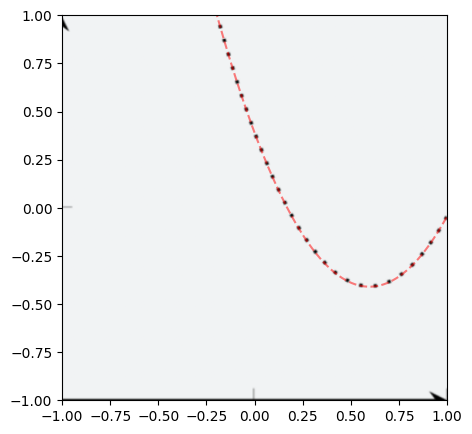

In [4]:
import matplotlib.pyplot as plt
BLUE = -1
RED = 1

img = plt.imread("cropped_curve.png")
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img, extent=[-1, 1, -1, 1])

def curve(x):
    return 2.247*(x-0.5965)**2 - 0.41

@np.vectorize
def generate_data_point(x, y):
    data_point = None
    if y > curve(x):
        return np.random.choice([BLUE, RED], size=1, p=[0.8, 0.2])[0]
    elif y <= curve(x):
        return np.random.choice([BLUE, RED], size=1, p=[0.2, 0.8])[0]
    
def generate_data_points(n):
    x1 = np.linspace(-1, 1, 50)
    x2 = np.linspace(-1, 1, 50)
    X1, X2 = np.meshgrid(x1, x2)

    random_x1_indices = random.sample([i for i in range(X1.ravel().shape[0])], n)
    random_x2_indices = random.sample([i for i in range(X2.ravel().shape[0])], n)

    random_x1_values = X1.ravel()[random_x1_indices]
    random_x2_values = X2.ravel()[random_x2_indices]
    X = np.array([[x1, x2] for x1, x2 in zip(random_x1_values, random_x2_values)])
    y = np.array([generate_data_point(x1, x2) for x1, x2 in zip(random_x1_values, random_x2_values)])
    return X, y

x = np.linspace(-0.5, 1.0, 1000)
plt.plot(x, curve(x), "r--", alpha=0.5)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colorizer import Colorizer
from matplotlib.colors import ListedColormap

def scatter_points(ax, X, y):
    for x, _y in zip(X, y):
        if _y == RED:
            color = "red"
            marker = '1'
        elif _y == BLUE:
            color = "blue" 
            marker = '2'
        # ax.scatter(x[0], x[1], color=color, marker=marker)
        ax.scatter(x[0], x[1], color=color)

def plot_decision_regions(ax, classifier, xlim=[-1, 1], ylim=[-1, 1]):
    colorizer=Colorizer(ListedColormap(['cornflowerblue', 'lightcoral']))
    
    x1 = np.linspace(xlim[0], xlim[1], 100)
    x2 = np.linspace(ylim[0], ylim[1], 100)

    @np.vectorize
    def calculate_z(x1, x2):
        return classifier.predict([[x1, x2]])[0]

    X1, X2 = np.meshgrid(x1, x2)
    Z = calculate_z(X1, X2)

    # for (x1, x2), z in zip(zip(X1.ravel(), X2.ravel()), Z.ravel()):
    #     if x1 > 0.5 and x2>0.1:
    #         pass
    ax.pcolormesh(X1, X2, Z, colorizer=colorizer)

# n = 200

# random_x = np.random.uniform(-1, 1, n)
# random_y = np.random.uniform(-1, 1, n)

# X = np.array([[x, y] for x, y in zip(random_x, random_y)])
# y = np.array([generate_data_point(x, y) for x, y in zip(random_x, random_y)])

(-1.0, 1.0)

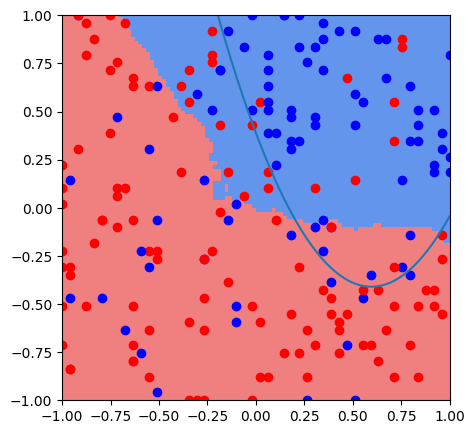

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

n = 200
k = 70

X, y = generate_data_points(n)
classifier_k70 = KNeighborsClassifier(n_neighbors=k, algorithm="brute").fit(X, y)

plot_decision_regions(ax, classifier_k70)
scatter_points(ax, X, y)

x = np.linspace(-1, 1, 1000)
ax.plot(x, curve(x))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

(-1.0, 1.0)

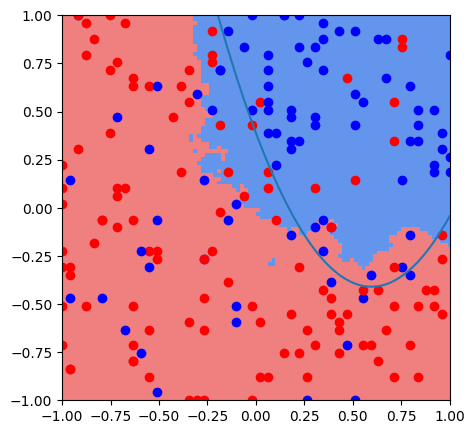

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

# n = 200
k = 20

# X, y = generate_data_points(n)
classifier_k20 = KNeighborsClassifier(n_neighbors=k, algorithm="brute").fit(X, y)

plot_decision_regions(ax, classifier_k20)
scatter_points(ax, X, y)

x = np.linspace(-1, 1, 1000)
ax.plot(x, curve(x))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

(-1.0, 1.0)

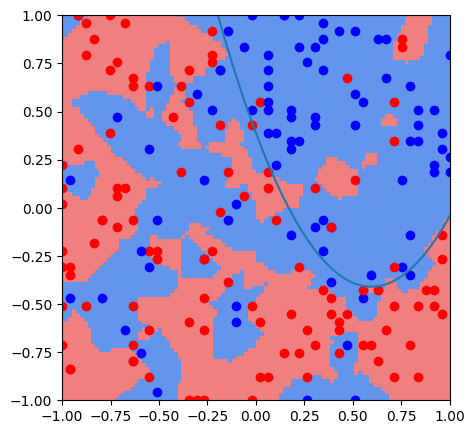

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

# n = 200
k = 2

# X, y = generate_data_points(n)
classifier_k2 = KNeighborsClassifier(n_neighbors=k, algorithm="ball_tree").fit(X, y)

plot_decision_regions(ax, classifier_k2)
scatter_points(ax, X, y)

x = np.linspace(-1, 1, 1000)
ax.plot(x, curve(x))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

In [9]:
from sklearn.metrics import mean_squared_error

def missclassification_rate(y_true, y_pred):
    n = len(y_true)
    
    num_errors = np.sum([0 if y_t == y_p else 1 for y_t, y_p in zip(y_true, y_pred)])
    
    return num_errors / n

classifier_error = {
    classifier_k70.n_neighbors: {"train_error": [], "new_error": []},
    classifier_k20.n_neighbors: {"train_error": [], "new_error": []},
    classifier_k2.n_neighbors: {"train_error": [], "new_error": []},
    3: {"train_error": [], "new_error": []},
}

N = 100

for _ in range(N):
    X_train, y_train = generate_data_points(n)
    X_test, y_test = generate_data_points(n)
    for k, data in classifier_error.items():
        classifier = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        data["train_error"].append(missclassification_rate(y_train, classifier.predict(X_train)))
        data["new_error"].append(missclassification_rate(y_test, classifier.predict(X_test)))



In [10]:
print(np.sum(classifier_error[70]["train_error"])/N)
print(np.sum(classifier_error[70]["new_error"])/N)

print(np.sum(classifier_error[20]["train_error"])/N)
print(np.sum(classifier_error[20]["new_error"])/N)

print(np.sum(classifier_error[2]["train_error"])/N)
print(np.sum(classifier_error[2]["new_error"])/N)

print(np.sum(classifier_error[3]["train_error"])/N)
print(np.sum(classifier_error[3]["new_error"])/N)


0.23349999999999993
0.24775000000000005
0.21895
0.24055000000000004
0.16465
0.3680999999999999
0.166
0.27795000000000003


# Problem 3 - Recreating Ex. 4.2

After languishing over not getting the right results, I have discovered that there is a typo in the textbook. It seems that n=20 for this problem, not 10.

In [11]:
def simulate_data(n):
    x = random.sample(list(np.linspace(-5, 10, 10000)), n)
    X = np.array([[_x] for _x in x])
    
    y_mean = np.array([min(_y, 3) for _y in 0.1*np.array(x)**2])
    y = y_mean + np.random.normal(0, 1, n)
    return X, y
    

Make sure that I understand how alpha (from sklearn) and lambda (from textbook) relate. I determined that 
$$\alpha = n \lambda$$

In [12]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
lam = 10.0
n = 10
X_train, y_train = simulate_data(n)
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
ridge = Ridge(alpha=n*lam, fit_intercept=False).fit(X_poly_train, y_train)

thetas = np.linalg.inv((X_poly_train.T@X_poly_train) + n*lam*np.eye(3))@X_poly_train.T @y_train
print(thetas)
print(ridge.coef_)

X_test, y_test = simulate_data(1)
X_poly_test = poly.fit_transform(X_test)

[0.02515653 0.03722494 0.06892744]
[0.02515653 0.03722494 0.06892744]


In [13]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

def get_metrics_quadratic(n, lam, order=2):
    X_train, y_train = simulate_data(n)
    poly = PolynomialFeatures(degree=order)
    X_poly_train = poly.fit_transform(X_train)
    ridge = Ridge(alpha=n*lam, fit_intercept=False).fit(X_poly_train, y_train)
    E_train = mean_squared_error(y_train, ridge.predict(X_poly_train))
    
    X_test, y_test = simulate_data(10*n)
    X_poly_test = poly.fit_transform(X_test)
    E_test = mean_squared_error(y_test, ridge.predict(X_poly_test))
    
    return E_train, E_test

def get_metrics_tree(n, tree_depth):
    X_train, y_train = simulate_data(n)
    tree = DecisionTreeRegressor(max_depth=tree_depth).fit(X_train, y_train)
    E_train = mean_squared_error(y_train, tree.predict(X_train))

    X_test, y_test = simulate_data(10*n)
    E_test = mean_squared_error(y_test, tree.predict(X_test))

    return E_train, E_test
    

In [14]:
def generalisation_gap_vs_e_train(ax, get_metrics_func, meta_parameters, label="", n=20, color='red', M=1000):
    metrics = {meta_param: {"E_train": 0, "E_test": 0} for meta_param in meta_parameters}

    for reg_param in metrics.keys():
        E_train, E_test = [], []
        for _ in range(M):
            _E_train, _E_test = get_metrics_func(n, reg_param)
            E_train.append(_E_train)
            E_test.append(_E_test)

        metrics[reg_param]["E_train"] = np.sum(np.array(E_train))/M
        metrics[reg_param]["E_test"] = np.sum(np.array(E_test))/M

    train_error = []
    generalisation_gap = []
    meta_params = []

    for meta_param, data in metrics.items():
        train_error.append(data['E_train'])
        generalisation_gap.append(data['E_test'] - data['E_train'])
        meta_params.append(meta_param)

    ax.plot(train_error, generalisation_gap, color=color, label=label)
    for meta_param, (x, y) in zip(meta_params, zip(train_error, generalisation_gap)):
        ax.scatter(x, y, color=color)
        ax.annotate(f"{meta_param}", xy=(x, y))
    
    ax.set_xlabel(r"$E_{train}$")
    ax.set_ylabel(r"Generalisation Gap")

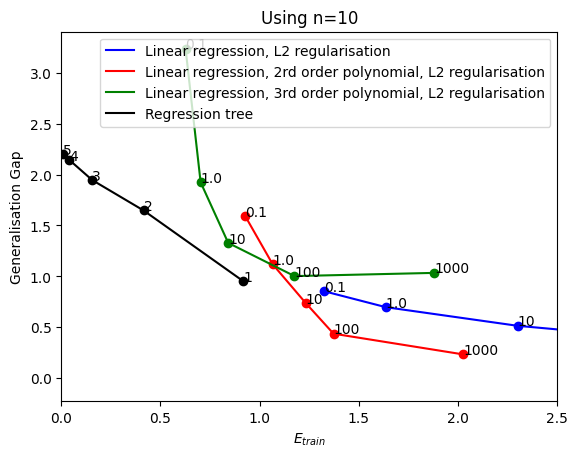

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
n=10
# generalisation_gap_vs_e_train(ax, get_metrics_quadratic, [0.1, 1.0, 10, 100, 1000], n=n, color='red', label="")
generalisation_gap_vs_e_train(ax, lambda n, lam: get_metrics_quadratic(n, lam, order=1), [0.1, 1.0, 10, 100, 1000], n=n, color='blue', label="Linear regression, L2 regularisation")
generalisation_gap_vs_e_train(ax, lambda n, lam: get_metrics_quadratic(n, lam, order=2), [0.1, 1.0, 10, 100, 1000], n=n, color='red', label="Linear regression, 2rd order polynomial, L2 regularisation")
generalisation_gap_vs_e_train(ax, lambda n, lam: get_metrics_quadratic(n, lam, order=3), [0.1, 1.0, 10, 100, 1000], n=n, color='green', label="Linear regression, 3rd order polynomial, L2 regularisation")
generalisation_gap_vs_e_train(ax, get_metrics_tree, [5, 4, 3, 2, 1], n=n, color='black', label="Regression tree")
plt.title(f"Using n={n}")
plt.xlim([0, 2.5])
plt.legend()
plt.show()

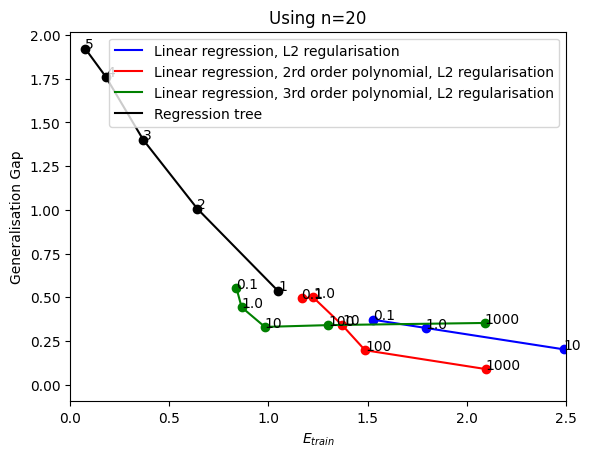

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
n=20
# generalisation_gap_vs_e_train(ax, get_metrics_quadratic, [0.1, 1.0, 10, 100, 1000], n=n, color='red', label="")
generalisation_gap_vs_e_train(ax, lambda n, lam: get_metrics_quadratic(n, lam, order=1), [0.1, 1.0, 10, 100, 1000], n=n, color='blue', label="Linear regression, L2 regularisation")
generalisation_gap_vs_e_train(ax, lambda n, lam: get_metrics_quadratic(n, lam, order=2), [0.1, 1.0, 10, 100, 1000], n=n, color='red', label="Linear regression, 2rd order polynomial, L2 regularisation")
generalisation_gap_vs_e_train(ax, lambda n, lam: get_metrics_quadratic(n, lam, order=3), [0.1, 1.0, 10, 100, 1000], n=n, color='green', label="Linear regression, 3rd order polynomial, L2 regularisation")
generalisation_gap_vs_e_train(ax, get_metrics_tree, [5, 4, 3, 2, 1], n=n, color='black', label="Regression tree")
plt.title(f"Using n={n}")
plt.xlim([0, 2.5])
plt.legend()
plt.show()

# Problem 4


# Problem 5

Precision and recall defined on page 86
Examples of ROC and precision recall curves on page 88

(a)

In [35]:
def calculate_x(n=1000):
    return np.random.choice([1, -1], size=n, p=[0.7, 0.3])

@np.vectorize
def _calculate_y_from_z(z, r):
    if z > r:
        return 1
    else:
        return -1

def calculate_y(x, r=0):
    n = x.shape[0]
    z = x + np.random.normal(0, 1.0, n)
    y = _calculate_y_from_z(z, r)
    return y

def calculate_confusion_matrix(r=0, n=1000):
    r = np.atleast_1d(r)
    confusion_matrix = {
        "TN": np.zeros_like(r),
        "FN": np.zeros_like(r),
        "FP": np.zeros_like(r),
        "TP": np.zeros_like(r),
        "N": np.zeros_like(r),
        "P": np.zeros_like(r),
        "N*": np.zeros_like(r),
        "P*": np.zeros_like(r),
        "n": np.zeros_like(r),
    }
    x = calculate_x(n=n)

    for i, _r in enumerate(r):
        y = calculate_y(x, _r)
        for xi, yi in zip(x, y):
            if xi == -1 and yi==-1:
                confusion_matrix["TN"][i] += 1
            elif xi == -1 and yi==1:
                confusion_matrix["FP"][i] += 1
            elif xi == 1 and yi==-1:
                confusion_matrix["FN"][i] += 1
            elif xi == 1 and yi==1:
                confusion_matrix["TP"][i] += 1
            else:
                pass
        
        confusion_matrix["N"][i] = confusion_matrix["TN"][i] + confusion_matrix["FP"][i]
        confusion_matrix["P"][i] = confusion_matrix["FN"][i] + confusion_matrix["TP"][i]
        confusion_matrix["N*"][i] = confusion_matrix["TN"][i] + confusion_matrix["FN"][i]
        confusion_matrix["P*"][i] = confusion_matrix["FP"][i] + confusion_matrix["TP"][i]
        confusion_matrix["n"][i] = len(x)
    return confusion_matrix

In [36]:
calculate_confusion_matrix(r=0, n=1000)

{'TN': array([268]),
 'FN': array([103]),
 'FP': array([60]),
 'TP': array([569]),
 'N': array([328]),
 'P': array([672]),
 'N*': array([371]),
 'P*': array([629]),
 'n': array([1000])}

(b)

In [37]:
def calculate_false_positive_rate(confusion_matrix):
    return confusion_matrix["FP"] / (confusion_matrix["N"])

def calculate_true_positive_rate(confusion_matrix):
    return confusion_matrix["TP"] / (confusion_matrix["P"])

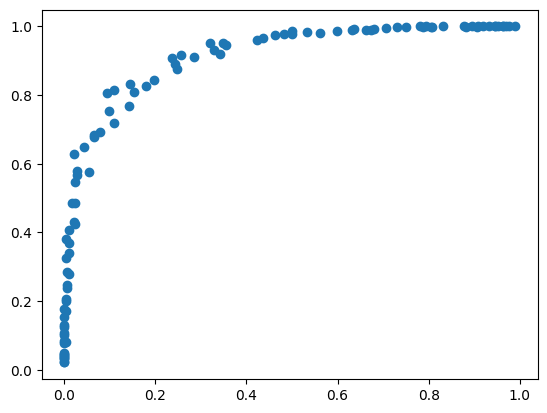

In [72]:
# Calculate the ROC curve (true positive rate vs false positive rate)
r = np.linspace(-3, 3, 100)
conf_mat = calculate_confusion_matrix(r=r, n=1000)
tp_rate = calculate_true_positive_rate(conf_mat)
fp_rate = calculate_false_positive_rate(conf_mat)

plt.scatter(fp_rate, tp_rate)

(c)

In [55]:
def calculate_recall(confusion_matrix):
    return confusion_matrix["TP"] / (confusion_matrix["P"])

def calculate_precision(confusion_matrix):
    return confusion_matrix["TP"] / (confusion_matrix["P*"])

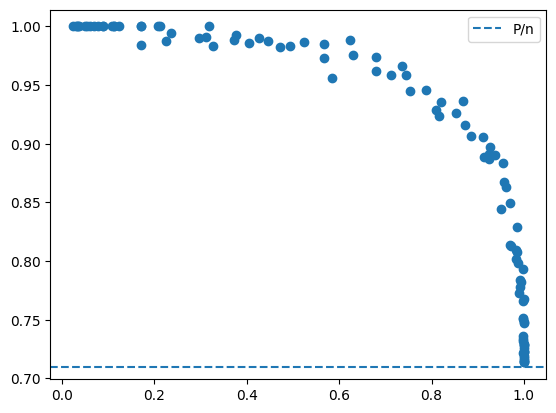

In [78]:
r = np.linspace(-3, 3, 100)
conf_mat = calculate_confusion_matrix(r=r, n=1000)
recall = calculate_recall(conf_mat)
precision = calculate_precision(conf_mat)

plt.scatter(recall, precision)
plt.axhline((conf_mat["P"]/conf_mat["n"])[0], linestyle="--", label="P/n")
plt.legend()

(d)
What values of r give the best predictors according to each curve? Are they the same? Why or
why not?